## Using kNN-statistics on an N-body simulation

We explore the use of kNN-CDFs, CICs, VPFs and other statistics for halos and the DM distribution as found in the Bolshoi simulation. We use all public tools including <a href="http://halotools.readthedocs.io">halotools</a>, and <a href="http://colossus.readthedocs.io">colossus</a>. Please make sure you have those installed already.


In [1]:
import halotools
import halotools.mock_observables as mo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial
import h5py
import os
from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.lss import bias
from scipy import interpolate
from scipy import integrate
import time
from Corrfunc.theory.xi import xi
from Corrfunc.theory.DD import DD
from Corrfunc.utils import convert_3d_counts_to_cf

import scipy.stats as stats

from kNN_CDFs import CDFkNN
from scipy.interpolate import interp1d

import sys
sys.path.append('/Users/tabel/Research/codes/SEdist/')
from SEdist import SE_distribution

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
nthreads = 4
# plt.style.use(style.notebook)
plt.rc("text", usetex=True)
plt.rcParams["font.size"] = 32
plt.rcParams["figure.figsize"] = [16.34, 13]

In [2]:
from halotools.sim_manager import CachedHaloCatalog

bolshoi_z0 = CachedHaloCatalog()
halos = bolshoi_z0.halo_table
particles = bolshoi_z0.ptcl_table
Nhalosin = len(bolshoi_z0.halo_table)
boxsize = 250
print("Number of Halos: ", len(halos))

Number of Halos:  1367493


## Create Subsamples

To explore various clustering measures we examine halos and define some sub-samples based on virial mass.

In [3]:
msel = np.sort(halos["halo_mvir"])
halos.sort("halo_mvir")
mthresh = np.array((5e10, 1e11, 1e12, 1e13, 1e14))
ithresh = np.arange(5)
Nhthresh = np.arange(5)
count = 0
for i in mthresh:
    ithresh[count] = (np.where(msel >= i))[0][0]
    Nhthresh[count] = Nhalosin - ithresh[count] + 1
    print(
        "Greater than %8.2e Msun has %7g halos"
        % (msel[ithresh[count]], Nhthresh[count])
    )
    count = count + 1

Greater than 5.00e+10 Msun has  917419 halos
Greater than 1.00e+11 Msun has  499166 halos
Greater than 1.00e+12 Msun has   61815 halos
Greater than 1.00e+13 Msun has    6161 halos
Greater than 1.00e+14 Msun has     327 halos


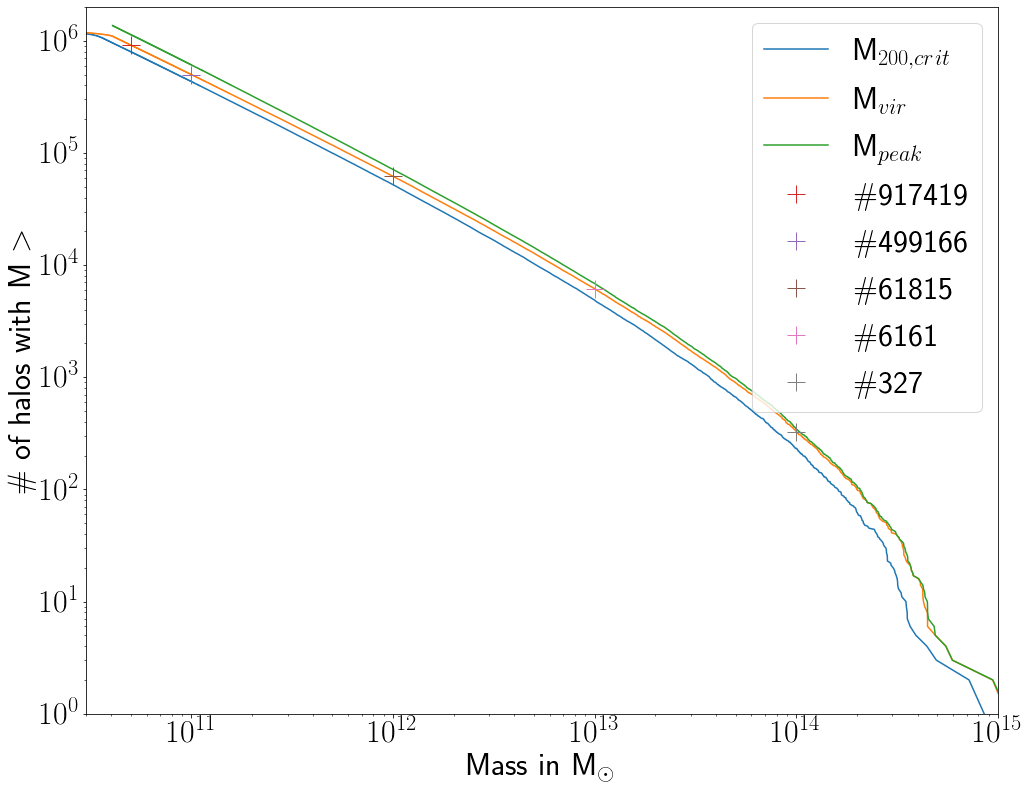

In [4]:
xMh = Nhalosin - np.arange(Nhalosin)
plt.loglog(np.sort(halos["halo_m200c"]), xMh, label=r"M$_{200,crit}$")
plt.semilogy(np.sort(halos["halo_mvir"]), xMh, label=r"M$_{vir}$")
plt.semilogy(np.sort(halos["halo_mpeak"]), xMh, label=r"M$_{peak}$")
for c, i in enumerate(ithresh):
    plt.plot(
        halos["halo_mvir"][i],
        xMh[i],
        "+",
        markersize=18,
        label=r"\#" + str(Nhthresh[c]),
    )
plt.xlabel("Mass in M$_\odot$")
plt.ylabel("$\#$ of halos with M $>$ ")
plt.xlim((3e10, 1e15))
plt.ylim((1, 2e6))

plt.legend(loc='upper right');

### Create a Poisson sample
A Poisson Distribution for testing along with a uniform lattice covering the simulation volume. We use a volume as in te Bolshoi simulation so coordinates are in the intervals $[0..250]\,Mpc\,h^{-1}$.

In [5]:
seed = 42
np.random.seed(seed)
NPois = 1000000
X = np.random.uniform(0, boxsize, NPois)
Y = np.random.uniform(0, boxsize, NPois)
Z = np.random.uniform(0, boxsize, NPois)

x_Poisson = np.vstack((X,Y,Z)).T.reshape(NPois, 3)

Nplg = int(NPois ** 0.3334) # make a lattice with approximately the same number as the input data
xpoi = boxsize * (np.arange(0, Nplg) + 0.5) / Nplg
xoutg = np.array(np.meshgrid(xpoi, xpoi, xpoi, indexing="xy"))
xoutg = xoutg.T.reshape(Nplg ** 3, 3)

Vbar = 250**3/NPois

## $kNN-CDFs$, Void Probability Function, and Counts in Cell

In [6]:

from scipy.special import gamma, gammaln
def Erlang(k, lam, x):
    if k == 0:
        klamx = lam * x
        gammak = 1
    else:
        klamx = k * lam * x
        gammak = gamma(k)
#    return (klamx) ** k / gammak * np.exp(-klamx)
    return np.exp(k*np.log(klamx) -klamx -gammaln(k))

In [7]:
Erlang(700,1, 10)


0.0

### Nearest Neighbor Estimates for the VPF

White (1979) describes the natural estimator to be the nearest neighbor counts. 
For a large number of randomly chosen points, ${N_{tot}}$, the fraction of these points which have nearest neighbor distances (to nearest galaxy), $r_{1NN}$ , within a given radius $r$,  
$$
g_{1NN}(r)=\frac{1}{N_{tot}} N(r_{1NN} \gt r),
$$
is an estimate of the void probability function. The generalization to $g_{kNN}(r)$ measuring the fraction of points with $k$ nearest neighbor distances larger than $r$ can further be used as an estimator for the counts in cell probabilities. 

In [ ]:
kneighbors = np.arange(550)+1 # get first __ nearest neighbors (starts at k=1)

### Measure kNN-CDFs

In [88]:
CDFs  = CDFkNN(x_Poisson, xoutg, kneighbors=kneighbors, periodic=250,compress="log",Ninterpolants=500)

### Calculate $P_k(V)$ from CDFs

In [9]:
Pks = { k-1: interp1d(CDFs[k].f.x,CDFs[k-1].cdf(CDFs[k].f.x)-CDFs[k].cdf(CDFs[k].f.x), bounds_error=False,fill_value=(0,0))  for k in kneighbors[1:]}
Pks.update({ 0: interp1d(CDFs[1].f.x,1-CDFs[1].cdf(CDFs[1].f.x), bounds_error=False,fill_value=(0,0)) })

### Assemble CICs from $P_k(V)$
Historically count in cell statistics are thought of as the distribution of counts of points in volumes of a specific size. Traditionally large numbers of spheres of given volume were created and then found how many points they contain. The fractional counts forms a discrete probability distribution.

In [10]:
vols = np.array([0.03,0.1,0.3,1,3,10,30,100])*Vbar
CICs = np.zeros((len(vols),len(kneighbors)))
for i, vol in enumerate(vols):
    CICs[i][:] = [Pks[k](vol) for k in kneighbors-1]

### Plot up CDFs, Pks and CICs

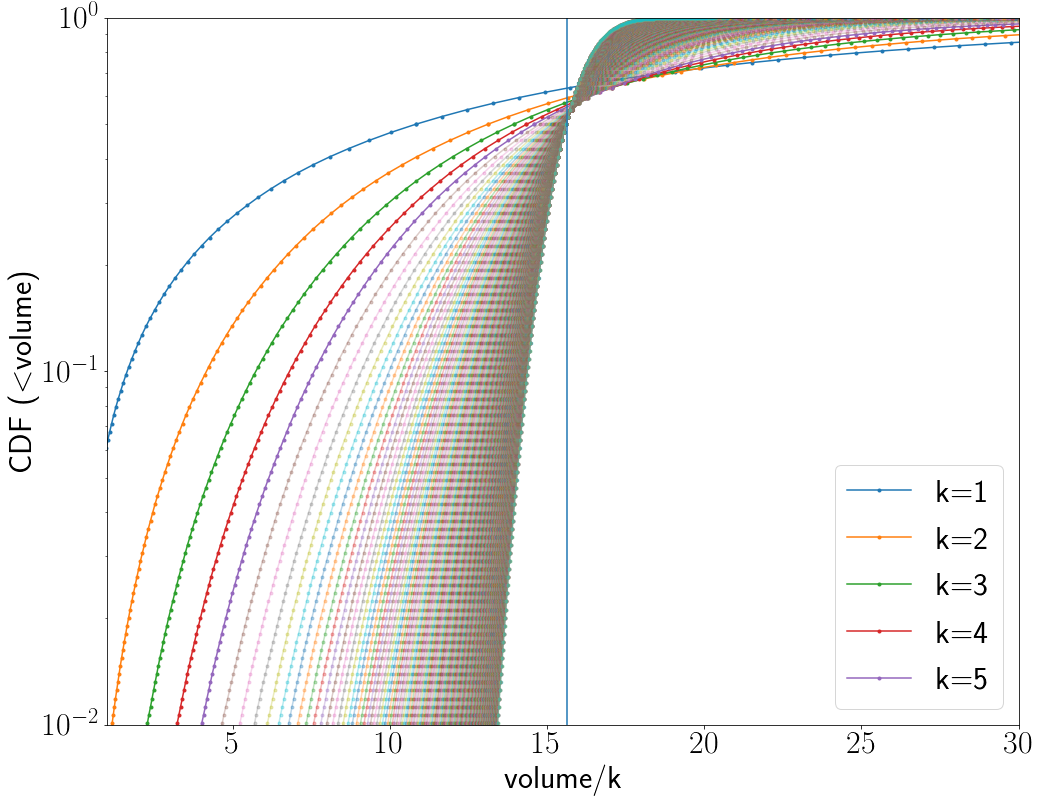

In [11]:
for k in kneighbors:
    vol = CDFs[k].f.x
    lab = ""
    af = 0.3
    if (k < 6) :
        lab = "k="+str(k)
        af = 1


    plt.semilogy(vol/k, CDFs[k].cdf(vol),'.-',alpha=af,label=lab)
plt.axvline(Vbar)
plt.xlim([1e0,30])
plt.ylim([1e-2,1])
plt.ylabel("CDF ($<$volume)")
plt.xlabel("volume/k")
plt.legend(loc="lower right");

We often prefer the peaked CDF as it also shows the right tail:

Text(0.5, 0, 'volume/k')

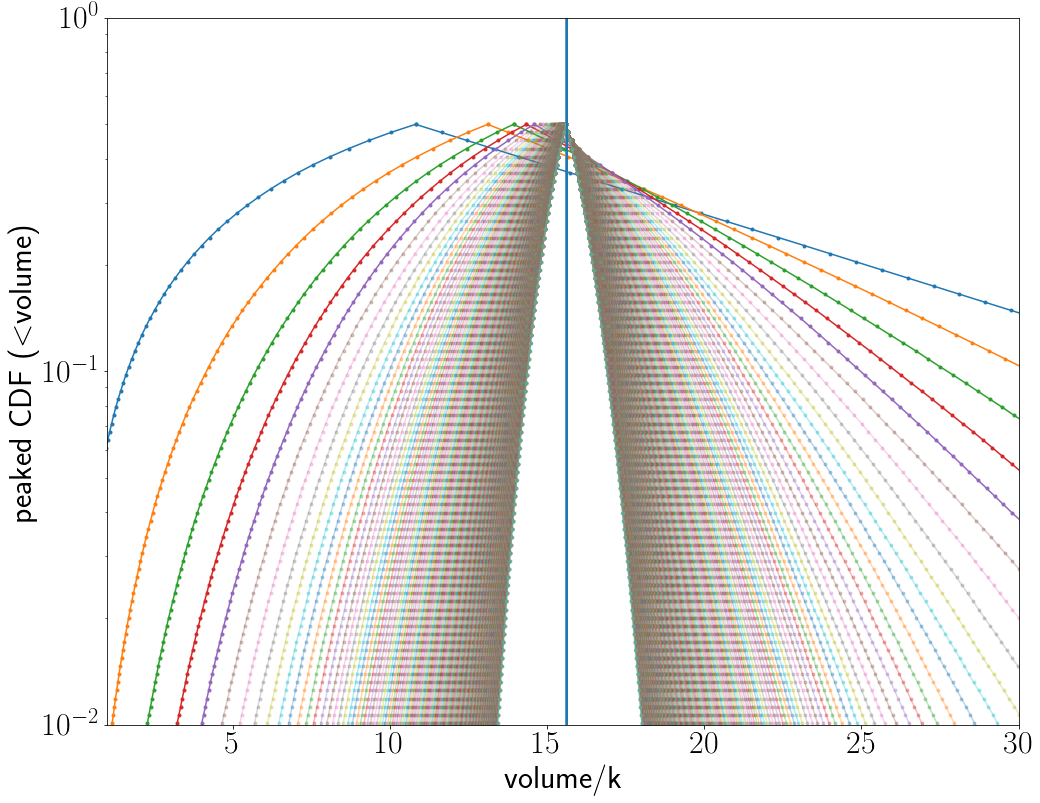

In [12]:
for k in kneighbors:
    vol = CDFs[k].f.x
    lab = ""
    af = 0.3
    if (k < 6) :
        lab = "k="+str(k)
        af = 1

    plt.semilogy(vol/k, CDFs[k].pcdf(vol),'.-',alpha=af, label=lab)
    plt.axvline(CDFs[k].mean()/k)
    
plt.axvline(Vbar)
plt.xlim([1e0,30])
plt.ylim([1e-2,1])
plt.ylabel("peaked CDF ($<$volume)")
plt.xlabel("volume/k")

/Users/tabel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  


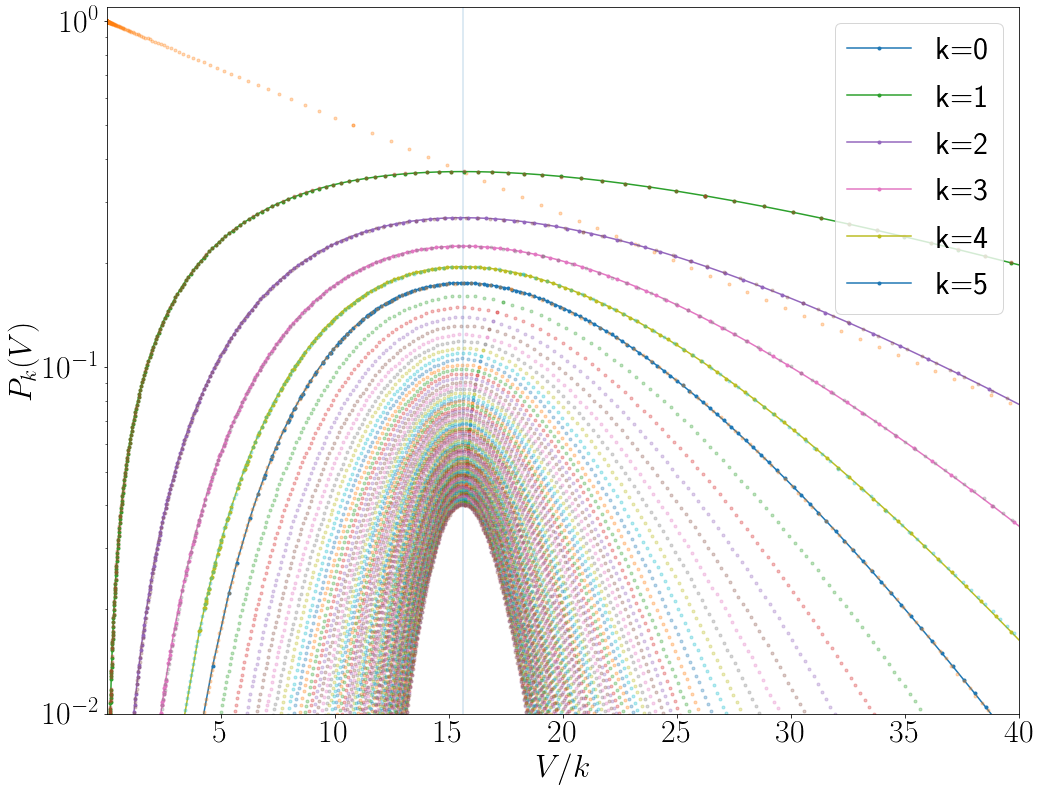

In [13]:
for k in range(100):
    vol = CDFs[k+1].f.x
    ck = np.max([k,1])
    lab = ""
    if (ck < 6) :
        lab = "k="+str(k)
        plt.plot(vol,Erlang(k,1/2.5**3,vol)/ck,'.-',label=lab)
    plt.semilogy(vol/ck, Pks[k](vol),'.',alpha=.3) 
plt.axhline(np.exp(-2.5**3))
plt.xlim([.01e0,40])
plt.ylim([1e-2,11e-1])
plt.ylabel(r"$P_{k}(V)$" )
plt.xlabel(r"$V/k$" )
plt.legend()
plt.axvline(Vbar,alpha=.2);

We over-plotted also the analytic expectation, the [Erlang distribution](https://en.wikipedia.org/wiki/Erlang_distribution), and we see that our million measurements follow it precisely in this Poisson tests. 

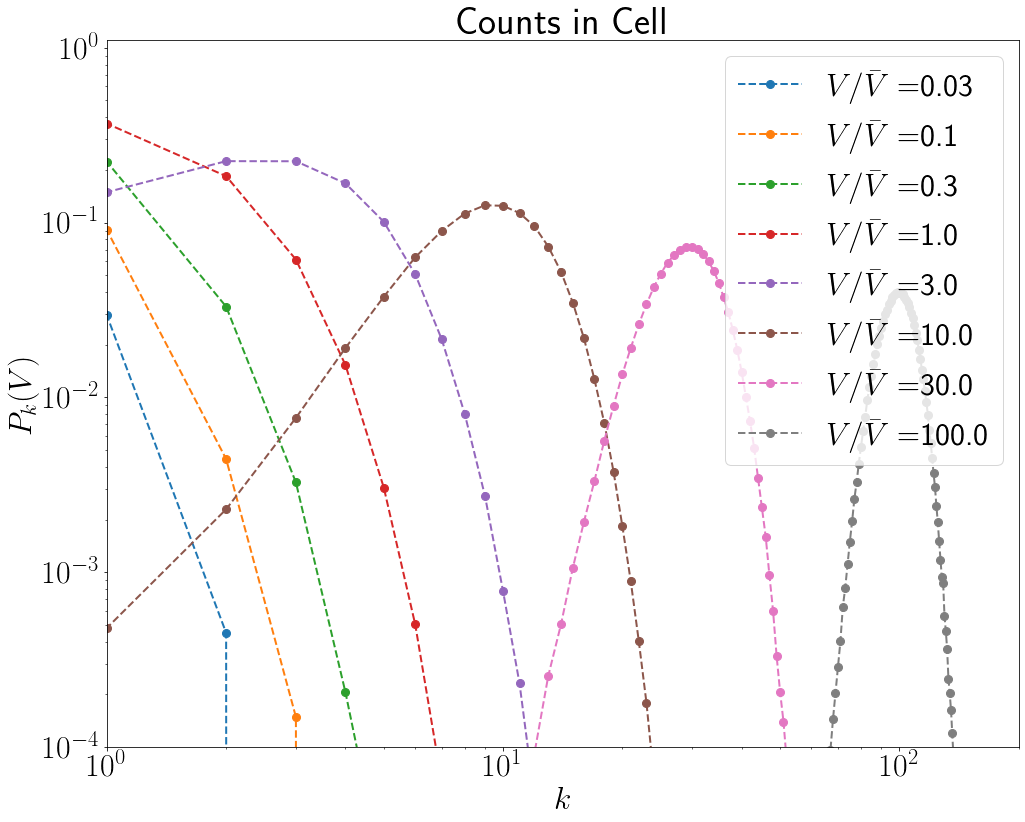

In [14]:
vols = np.array([0.03,0.1,0.3,1,3,10,30,100])*Vbar
CICs = np.zeros((len(vols),len(kneighbors)))
for i, vol in enumerate(vols):
    CICs[i][:] = [Pks[k](vol) for k in kneighbors-1]
    plt.loglog(kneighbors-1,CICs[i],'o--',lw=2,ms=8, label=r'${{V} / {\bar{V} }}=$'+str(vol/Vbar))

plt.title("Counts in Cell")
plt.xlim([1.e0,200])
plt.ylim([1e-4,11e-1])
plt.ylabel(r"$P_{k}(V)$" )
plt.xlabel(r"$k$" )
plt.legend(loc="upper right")
plt.axhline(Vbar,alpha=.2);


These counts in cell distributions are discrete probability distribution functions. I.e. $$\sum_{k=0}^{\infty} P_k(V) = 1$$.

### Now for the DM particles

In [15]:
Ndm = len(particles["x"])
x_dm = np.vstack((
    particles["x"],
    particles["y"],
    particles["z"])).T.reshape(Ndm, 3)
dVbar = 250**3/Ndm
t0 = time.time()
dCDFs  = CDFkNN(x_dm, xoutg, kneighbors=kneighbors, periodic=250,compress="log",Ninterpolants=300)
print("kNN estimate time take: ","{:6.2f}".format(time.time()-t0), " secs")

kNN estimate time take:   69.36  secs


In [16]:
dPks = { k-1: interp1d(dCDFs[k].f.x,dCDFs[k-1].cdf(dCDFs[k].f.x)-dCDFs[k].cdf(dCDFs[k].f.x), bounds_error=False,fill_value=(0,0))  for k in kneighbors[1:]}
dPks.update({ 0: interp1d(dCDFs[1].f.x,1-dCDFs[1].cdf(dCDFs[1].f.x), bounds_error=False,fill_value=(0,0)) })
vols = np.array([0.03,0.1,0.3,1,3,10,30,100])*dVbar
dCICs = np.zeros((len(vols),len(kneighbors)))
for i, vol in enumerate(vols):
    dCICs[i][:] = [dPks[k](vol) for k in kneighbors-1]

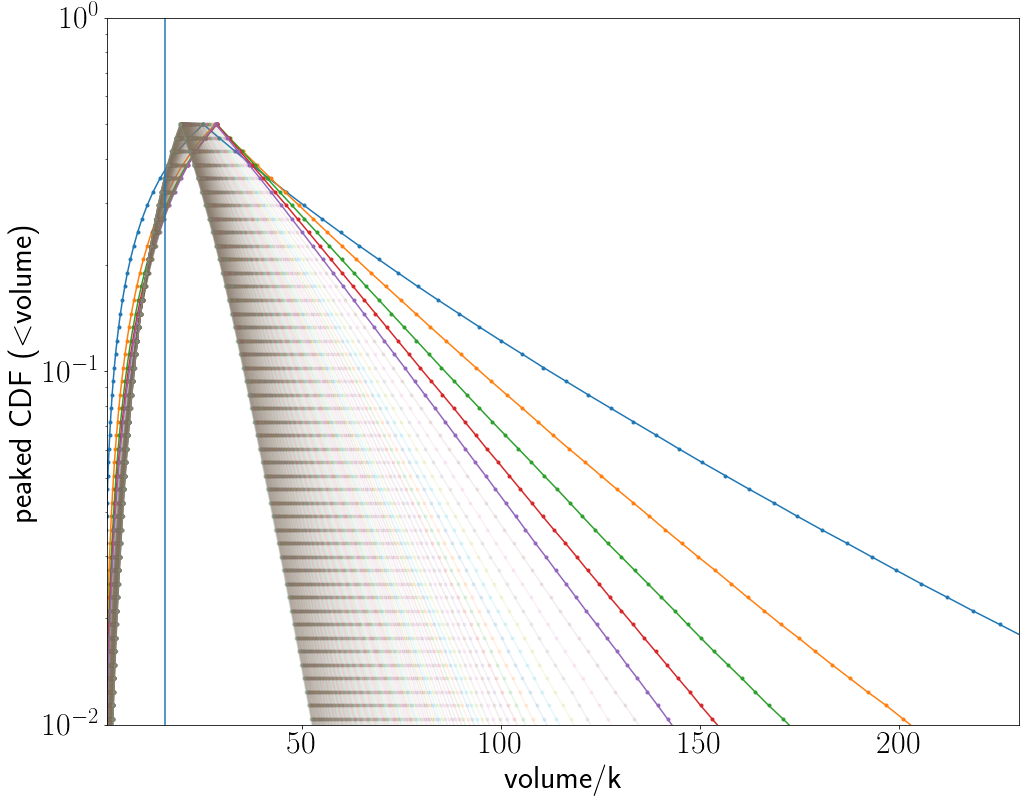

In [17]:
for k in kneighbors:
    vol = dCDFs[k].f.x
    lab = ""
    af = 0.1
    if (k < 6) :
        lab = "k="+str(k)
        af = 1

    plt.semilogy(vol/(k), dCDFs[k].pcdf(vol),'.-',alpha=af, label=lab)
plt.axvline(dVbar)
plt.xlim([1e0,230])
plt.ylim([1e-2,1])
plt.ylabel("peaked CDF ($<$volume)")
plt.xlabel("volume/k");

/Users/tabel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # Remove the CWD from sys.path while we load stuff.


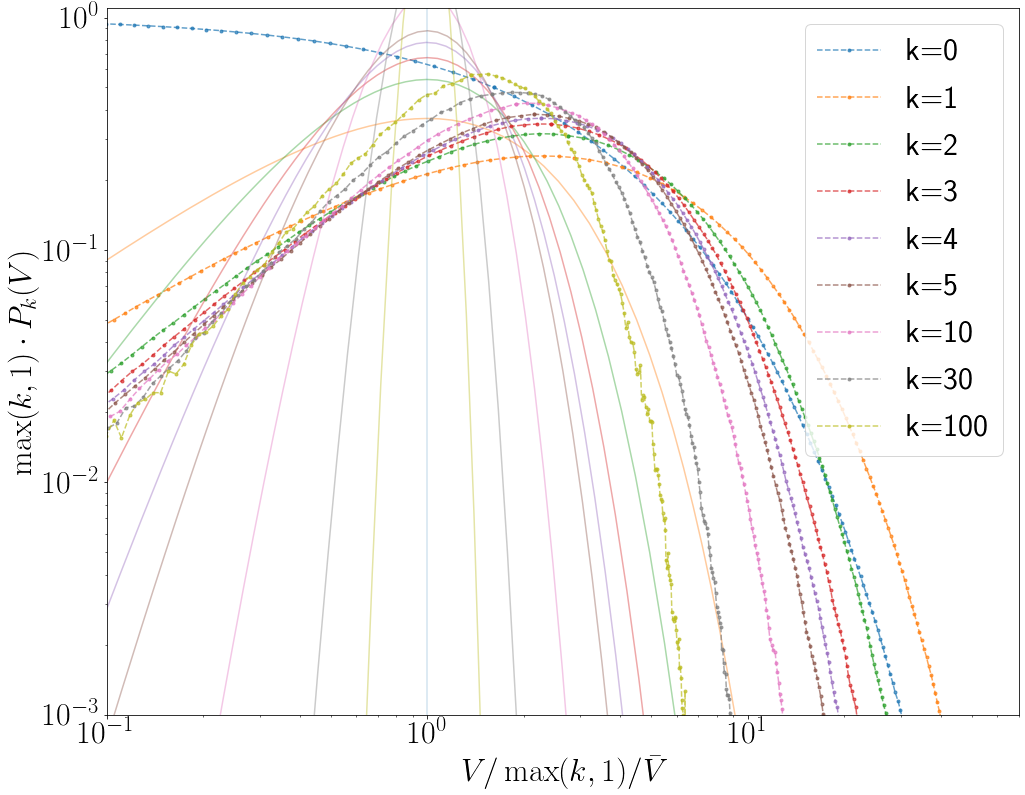

In [18]:
ax = plt.gca()
for k in [0,1,2,3,4,5,10,30,100]:
    vol = dCDFs[k+1].f.x
    ck = np.max([k,1])
    lab = ""
    c = next(ax._get_lines.prop_cycler)['color']
    lab = "k="+str(k)
    if (ck < 300) :
        plt.plot(vol/dVbar,ck*Erlang(k,1/2.5**3,vol)/ck,'-',alpha=.4,color=c)
    plt.semilogy((vol/ck/dVbar), ck*dPks[k](vol),'.--',alpha=.7,color=c,label=lab) 
plt.axhline(np.exp(-2.5**3))
plt.xscale("log")
plt.xlim([.1e0,70])
plt.ylim([1e-3,11e-1])
plt.ylabel(r"$\max(k,1) \cdot P_{k}(V)$" )
plt.xlabel(r"$V/\max(k,1)/\bar{V}$" )
plt.legend()
plt.axvline(1,alpha=.2);

Very noticeably the distributions of volumes associated with counting exactly k-points within them has become dramatically wider than expected in the Poisson case (thin light lines). The Void probability function is $P_0(V)$.

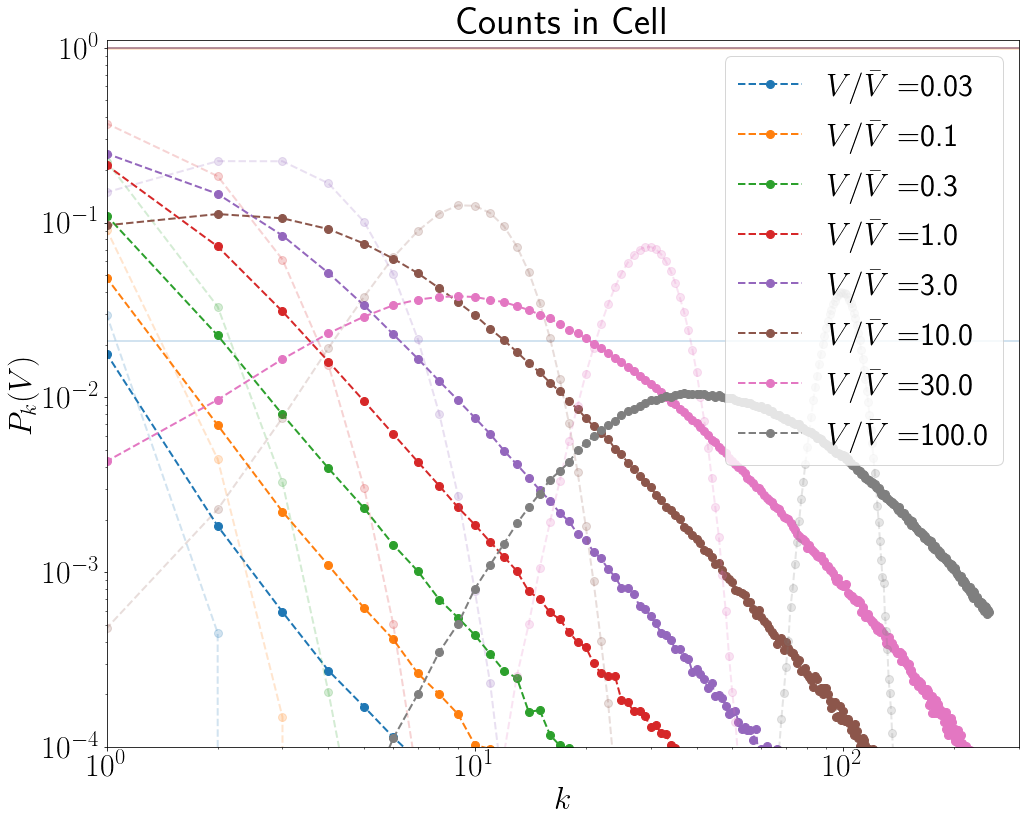

In [19]:
vols = np.array([0.03,0.1,0.3,1,3,10,30,100])*dVbar
ax = plt.gca()
for i, vol in enumerate(vols):
    c = next(ax._get_lines.prop_cycler)['color']
    plt.loglog(kneighbors-1,CICs[i],'o--',lw=2,ms=8,alpha=.2,color=c)
    plt.loglog(kneighbors-1,dCICs[i],'o--',lw=2,ms=8,color=c, label=r'${{V} / {\bar{V} }}=$'+str(vol/Vbar))
    plt.axhline(1-dCICs[0][i],lw=2,alpha=.2,color=c)

plt.title("Counts in Cell")
plt.xlim([1.e0,300])
plt.ylim([1e-4,11e-1])
plt.ylabel(r"$P_{k}(V)$" )
plt.xlabel(r"$k$" )
plt.legend(loc="upper right")
plt.axhline(Vbar,alpha=.2);


Here we recognize the Counts in Cell to be identical to a typical volume weighted density PDF (akin to nearest grid point assignment when gridding point data). We have the fractional probability of finding k number of points for a given volume. So the x axis with the number of counts can be thought of as density multiplied by the mean volume and the y-axis as $P(\rho) d\rho$. The variance at any scale now is derived from the width of these distributions. It is just that they are discrete distributions and one has probability mass function that depends on $k$ but they still all add to one. 

### CICs as discrete probability distributions
Here we illustrate the use of the Counts in Cell statistics considering them as discrete probability distributions. First using the Poisson data set from above we show how well this works and compare to analytic expectations. 

In [20]:
vols = np.logspace(-1,2,len(kneighbors))*Vbar
dCa = np.zeros((len(vols),len(kneighbors)))
for i, vol in enumerate(vols):
    dCa[i][:] = [Pks[k](vol) for k in kneighbors-1]

pC = [stats.rv_discrete(values=(kneighbors-1,np.round(dCa[i]/np.sum(dCa[i]), decimals=7)),\
    name='CountsInCell')  for i, vol in enumerate(vols)]

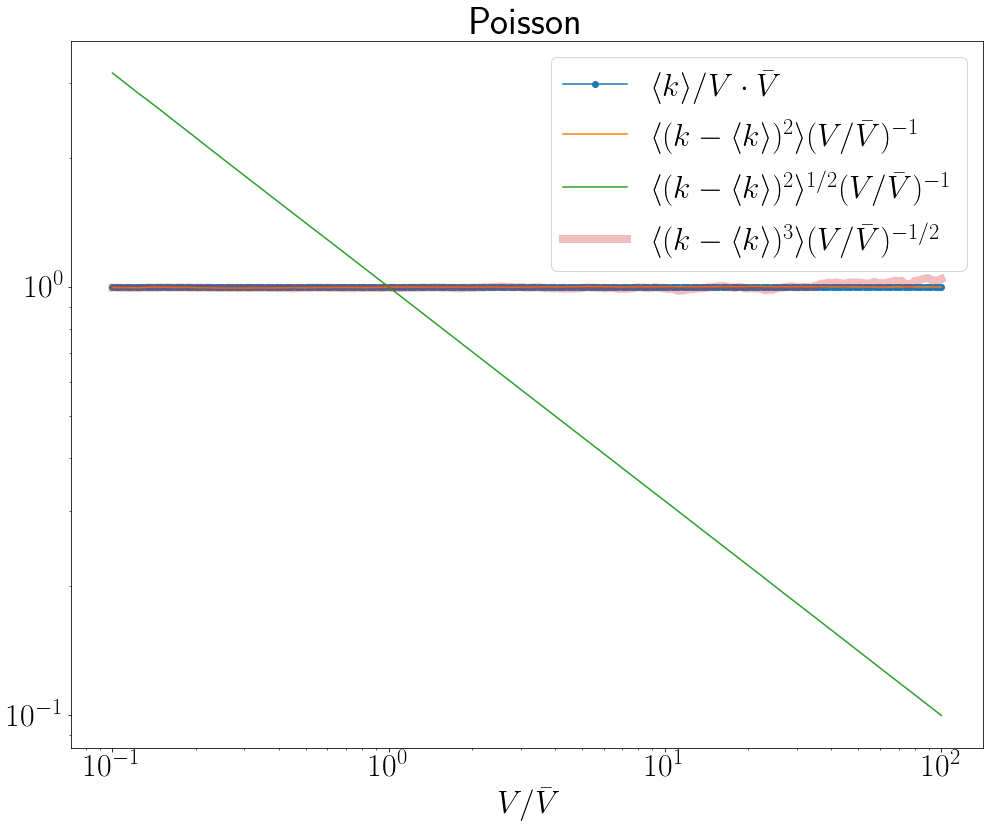

In [21]:
pkstat = np.array([pC[i].stats(moments="mvsk") for i, vol in enumerate(vols)])
pkstd = np.array([pC[i].std() for i, vol in enumerate(vols)])

pnv = vols/Vbar
plt.loglog(pnv, pkstat[:,0]/pnv,'o-',label=r"$\langle k \rangle/V \cdot \bar{V}$")
plt.plot(pnv, pkstat[:,1]/pnv, \
    label=r"$\langle (k - \langle k \rangle)^2 \rangle (V /\bar{V})^{-1}$")
plt.plot(pnv, pkstd/pnv, \
    label=r"$\langle (k - \langle k \rangle)^2 \rangle^{1/2} (V /\bar{V})^{-1}$")
plt.plot(pnv  , pkstat[:,2]/pnv**(-1/2),alpha=.3,lw=8, \
    label=r"$\langle (k - \langle k \rangle)^3 \rangle (V /\bar{V})^{-1/2}$")
#plt.plot(pnv  , pkstat[:,3]/pnv**(-1),alpha=.3,lw=4, \
#    label=r"$\langle (k - \langle k \rangle)^4 \rangle (V /\bar{V})^{-1}$")
plt.xlabel(r"$V/\bar{V}$")
plt.title("Poisson")
plt.legend();

In [22]:
vols = np.logspace(-2,2.3,len(kneighbors))*dVbar
dCa = np.zeros((len(vols),len(kneighbors)))
for i, vol in enumerate(vols):
    dCa[i][:] = [dPks[k](vol) for k in kneighbors-1]

dC = [stats.rv_discrete(values=(kneighbors-1,np.round(dCa[i]/np.sum(dCa[i]), decimals=7)),name='CountsInCell') \
    for i, vol in enumerate(vols)]


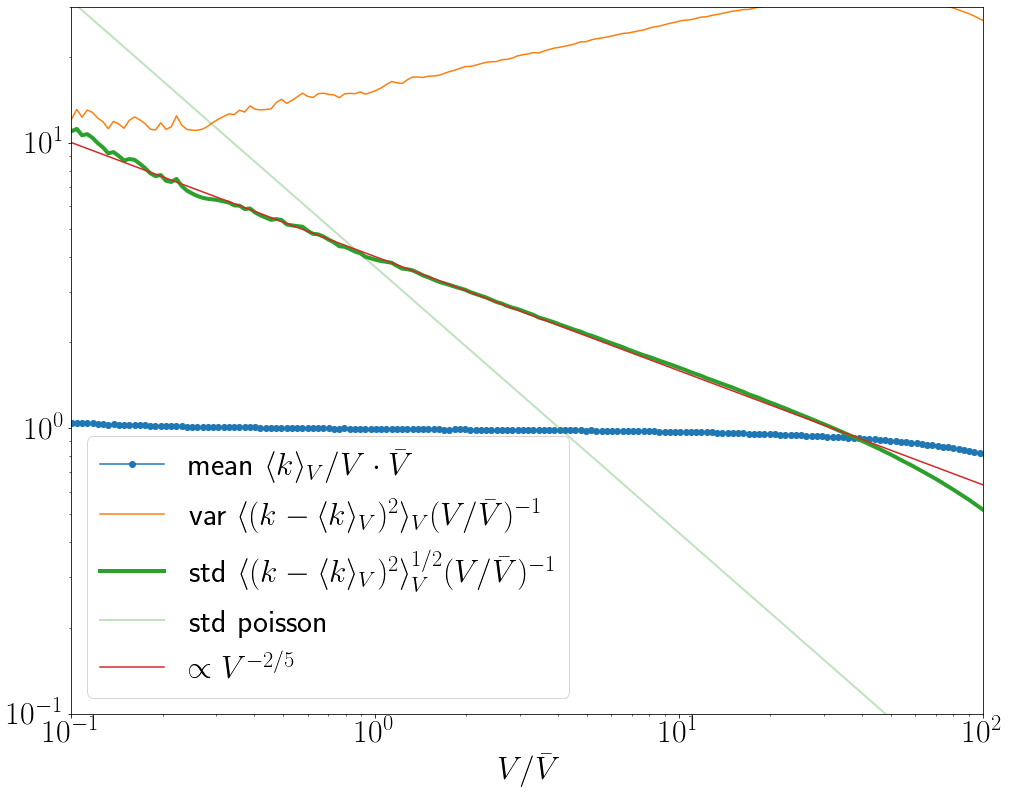

In [23]:
kstat = np.array([dC[i].stats(moments="mvsk") for i, vol in enumerate(vols)])
kstd = np.array([dC[i].std() for i, vol in enumerate(vols)])
ax = plt.gca()

nv = vols/dVbar
plt.loglog(nv, kstat[:,0]/nv,'o-',label=r"mean $\langle k \rangle_V/V \cdot \bar{V}$")
plt.plot(nv, kstat[:,1]/nv, \
    label=r"var $\langle (k - \langle k \rangle_V)^2 \rangle_V (V /\bar{V})^{-1}$")
c = next(ax._get_lines.prop_cycler)['color']
plt.plot(nv, kstd/nv, lw=4, color=c, \
    label=r"std $\langle (k - \langle k \rangle_V)^2 \rangle_V^{1/2} (V /\bar{V})^{-1}$")
plt.plot(pnv, pkstd/nv, lw=2, alpha=.3, color=c, \
    label=r"std poisson")
plt.plot([1e-2,1e2],np.array([1e-2,1e2])**(-1/2.5)*4, label=r"$\propto V^{-2/5}$")
#plt.plot(nv  , kstat[:,2]/nv**(-1/2),alpha=.3,lw=4, \
#    label=r"$\langle (k - \langle k \rangle)^3 \rangle_V (V /\bar{V})^{-1/2}$")
#plt.plot(nv  , kstat[:,3]/nv**(-1),alpha=.3,lw=4, \
#    label=r"$\langle (k - \langle k \rangle)^4 \rangle_V (V /\bar{V})^{-1}$")
plt.xlabel(r"$V/\bar{V}$")
plt.xlim(.1,1e2)
plt.ylim(.1,3e1)
plt.legend();

### On connections to tesselations

In [24]:
# demonstrate use of the direct volume measurements
# First make a grid with 2048x2048 pixels at one z coordinate for a quater of the box
# We measure for each point there the kNN volumes and visualize some of them.
from kNN_CDFs import VolumekNN
Niml = 2048
boxfrac = 0.25
xpoi = boxfrac * boxsize * (np.arange(0, Niml) + 0.5) / Niml
zcoord = 0.5 * boxsize # slice through center
ximg = np.array(np.meshgrid(xpoi, xpoi, indexing="xy"))
ximg = ximg.T.reshape(Niml ** 2, 2)
ks = [1,2,3]
ximg = np.vstack((ximg.T, (np.ones((Niml*Niml))*zcoord).T)).T
ximg.shape
kNNvol = VolumekNN(x_dm, ximg, k=ks, periodic=250)

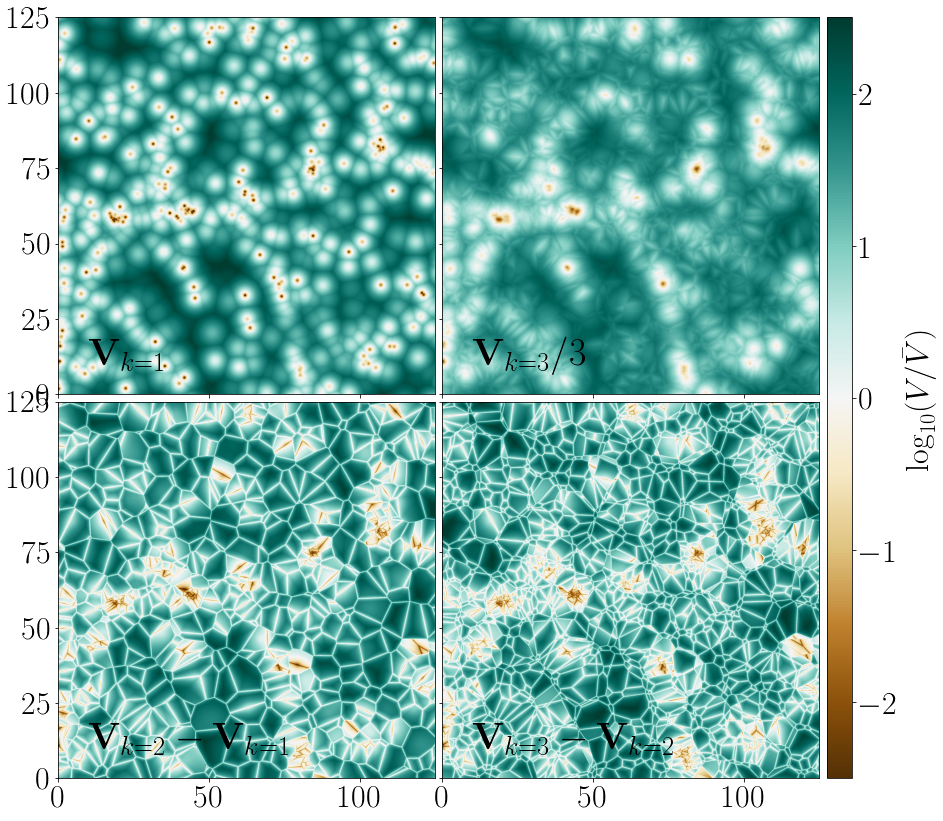

In [25]:
kNNimgs = kNNvol.reshape(Niml,Niml,len(ks))

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(17., 14.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

ct = 0
labels = [r"$\mathbf V_{k=1}$",r"$\mathbf V_{k=3}/3$", \
          r"$\mathbf V_{k=2}-\mathbf V_{k=1}$", r"$\mathbf V_{k=3}- \mathbf V_{k=2}$" ]
for ax, im in zip(grid, [np.log10(kNNimgs[:,:,0]), np.log10(kNNimgs[:,:,2]/3), \
#                        np.log10(kNNimgs[:,:,2]),  np.log10(kNNimgs[:,:,2]),  \
                        np.log10(kNNimgs[:,:,1]-kNNimgs[:,:,0]), np.log10(kNNimgs[:,:,2]-kNNimgs[:,:,1]) ]):
    # Iterating over the grid returns the Axes.
    dummy = ax.imshow(im,cmap="BrBG",extent=[0,ximg[0,:].max(),0,ximg[1,:].max()],vmin=-2.5,vmax=2.5)
    ax.text(10,10,labels[ct],fontsize=38,color="black")
    ct += 1

bbox_ax_top = grid[0].get_position()
bbox_ax_bottom = grid[2].get_position()

cbar_im1a_ax = fig.add_axes([.83, bbox_ax_top.y0, 0.02, bbox_ax_top.y1-bbox_ax_top.y0])
cbar_im1a = plt.colorbar(dummy, cax=cbar_im1a_ax,label=r"$\log_{10}(V/\bar{V})$")

#plt.show()
plt.savefig("kNN_CDF_tess.png",bbox_inches="tight",dpi=75)


In particular when we visualize the difference between kNN volumes we see the Vornoi tesselation. For each point that has the same distance to its first and its second neighbor it must lie on the Vornoi surface which delineates all the points that are closest to one data point as compared to the next. You also notice that most volumes measured in this highly clustered data set are larger than the mean volume indicating that most of the mass is at small volumes. Also notice that the densities we estimate are not the ones a Vornoi density estimator would create. For the latter densities per cell are constant. 

### VPFs of halos

Now lets compare with the traditional VPF approach from earlier.

Indeed the nearest neighbor density estimator measures exactly the void probability function without requiring binning.

One further clear advantage of the parameter free 1NN estimator is that is automatically picks out all volumes that can be meaningfully probed given the data.

## Comparison with two point function


In [244]:
nbins = 40
bins = np.logspace(-1.3, 1.7, nbins + 1)  # Note the + 1 to nbins, If you reduce the max to 1.3 (smaller max radius the calculation is much faster)
np.insert(bins, 0, 0.)

dm_xi = xi(
    boxsize,
    nthreads,
    bins,
    particles["x"],
    particles["y"],
    particles["z"],
    output_ravg=True,
    verbose=True,
)


In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 9,9,4.  Time taken =   0.046 sec
countpairs_xi_double> gridlink seems inefficient. nmesh = (9, 9, 4); avg_np = 3.09e+03. Boosting bin refine factor - should lead to better performance
xmin = 0.000000 xmax=250.000000 rmax = 50.118723
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 14,14,4.  Time taken =   0.047 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 35.061 secs


In [250]:
intxi = (dm_xi["xi"]*dm_xi["rmax"]**3-dm_xi["rmin"]**3).cumsum()/dm_xi["rmax"]**3
intxiV = dm_xi["rmax"]**3*4*np.pi/3

In [251]:
plt.rc("text", usetex=True)
plt.rcParams["font.size"] = 32

xivol = 4*np.pi/3*dm_xi["ravg"]**3
dCa = np.zeros((len(xivol),len(kneighbors)))
for i, vol in enumerate(xivol):
    dCa[i][:] = [dPks[k](vol) for k in kneighbors-1]

pC = [stats.rv_discrete(values=(kneighbors-1,np.round(dCa[i]/np.sum(dCa[i]), decimals=7)),\
    name='CountsInCell')  for i, vol in enumerate(xivol)]
xikstd = np.array([dC[i].std() for i, vol in enumerate(xivol)])

#ax = plt.step(dm_xi["rmin"], dm_xi["xi"], where="post", label="DM")
plt.step(intxiV, intxi,label=r"$\int 4\pi r^2 \xi(r)dr/\int 4\pi r^2 dr$")

ax = plt.plot(xivol/dVbar, dm_xi["xi"], label="DM", linewidth=4, alpha=0.5)
plt.plot(xivol/dVbar, 1000*xikstd/xivol**1, "X--", lw=4, color=c, \
    label=r"std $\langle (k - \langle k \rangle_V)^2 \rangle_V^{1/2} (V /\bar{V})^{-1}$")
plt.plot(xivol/dVbar, 10000*np.gradient(xikstd, xivol), lw=4, color=c, \
    label=r"std $\langle (k - \langle k \rangle_V)^2 \rangle_V^{1/2} (V /\bar{V})^{-1}$")

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title("Two point correlation function of dark matter")
plt.xlabel("Volume/Vbar")
plt.ylabel(r"$\xi(R)$")
plt.xlim(1e-1,1e2)
plt.ylim(1e-2,1e2)

KeyError: 250

## kNN-Density-CDFs
We have an opportunity to also interrogate the density field by looking at shells of volume measured by the difference from one neighbor to the next. 

In [ ]:
# demonstrate use of the direct density measurements
# First make a 3d grid with 100^3 voxels 
# We measure for each point there the kNN volumes and visualize some of them.
from kNN_CDFs import VolumekNN
v = VolumekNN(x_Poisson, xoutg, k=np.arange(10)+1, periodic=250)/Vbar

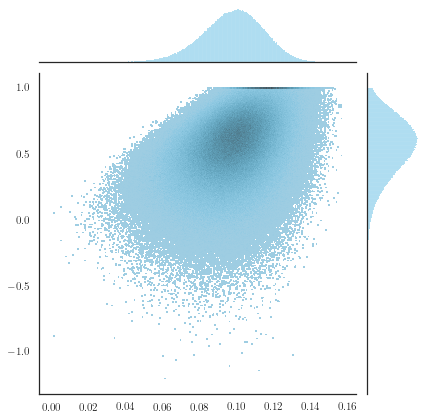

In [ ]:
import seaborn as sns
#plt.loglog((v[:,1]+v[:,0])/2, (v[:,1]-v[:,0])  ,'.', alpha=.03)
#plt.loglog((v[:,3]+v[:,2])/2, 1/(v[:,3]-v[:,2])  ,'.', alpha=.01)
tk = 9
off = 4
vb = np.log10(  (v[:,tk]+v[:,tk-off])/2).clip(-.5,1.5)/tk
dv = np.log10(  (v[:,tk]-v[:,tk-off])).clip(-2,1)

ind = np.logical_and(np.greater(vb, -0.5), np.less(vb,.5))
vb = vb[ind]
dv = dv[ind]

sns.set(style="white", color_codes=True)
sns.jointplot(x=vb, y=dv, kind='hist', color="skyblue");

#plt.xlim(-1,1)
#plt.ylim(-.5,2)

In [ ]:
np.sum(ind == True)

82706

## DD kNN-CDFs
There is a closely related technique where one thinks of data data pairs in the way we described above. It is rather different in that in this case the number of points where we make our measurements are also the data points. So we are not creating a continuous field like we did in the standard kNN-CDFs. Let us look at these differences now. 

In [119]:
import sys, importlib
importlib.reload(sys.modules['kNN_CDFs'])
from kNN_CDFs import CDFkNNDD
DDCDFs  = CDFkNNDD(x_Poisson, kneighbors=kneighbors, periodic=250,compress="log",Ninterpolants=500)

In [130]:
DDPks = { k-1: interp1d(DDCDFs[k].f.x,DDCDFs[k-1].cdf(DDCDFs[k].f.x)-DDCDFs[k].cdf(DDCDFs[k].f.x), 
bounds_error=False,fill_value=(0,0))  for k in kneighbors[1:]}
#DDPks.update({ 1: interp1d(DDCDFs[1].f.x, 1-DDCDFs[1].cdf(DDCDFs[1].f.x), bounds_error=False,fill_value=(0,0)) })

Text(0.5, 0, 'volume/k')

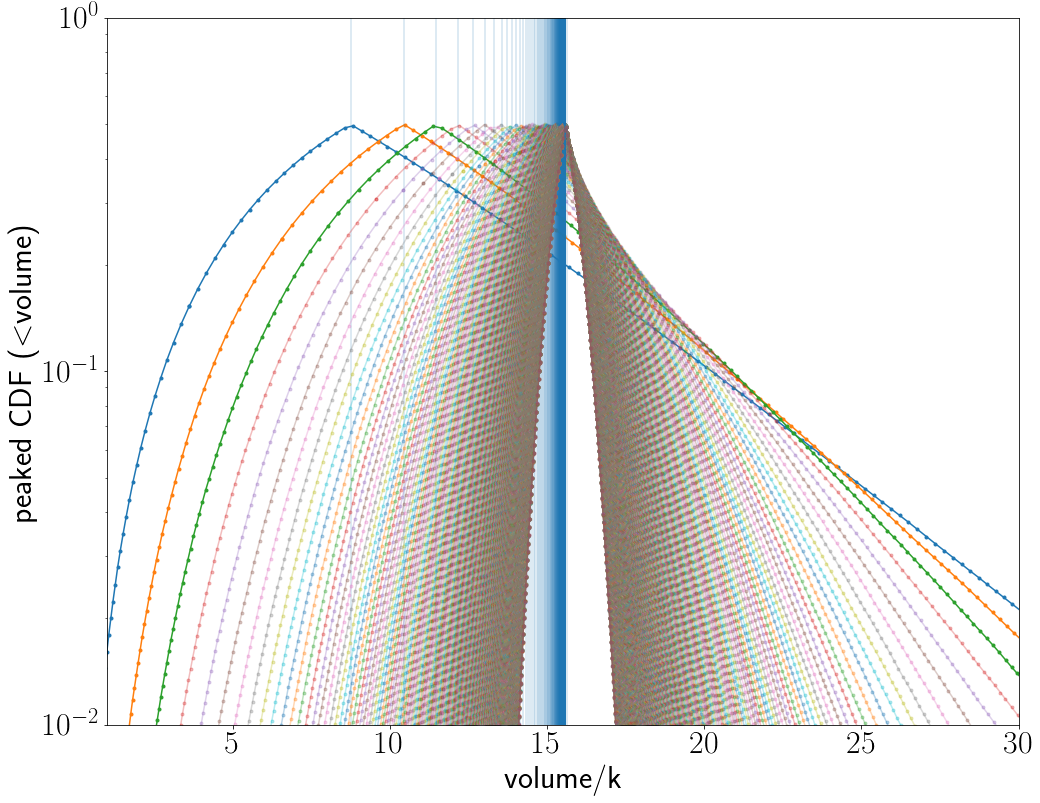

In [131]:
for k in kneighbors[2:-2]:
    vol = DDCDFs[k-1].f.x
    lab = ""
    af = 0.3
    if (k < 6) :
        lab = "k="+str(k)
        af = 1

    plt.semilogy(vol/k, DDCDFs[k].pcdf(vol),'.-',alpha=af, label=lab)
    plt.axvline(DDCDFs[k].median()/k,alpha=.2)
    
plt.axvline(Vbar,alpha=.2)
plt.xlim([1e0,30])
plt.ylim([1e-2,1])
plt.ylabel("peaked CDF ($<$volume)")
plt.xlabel("volume/k")

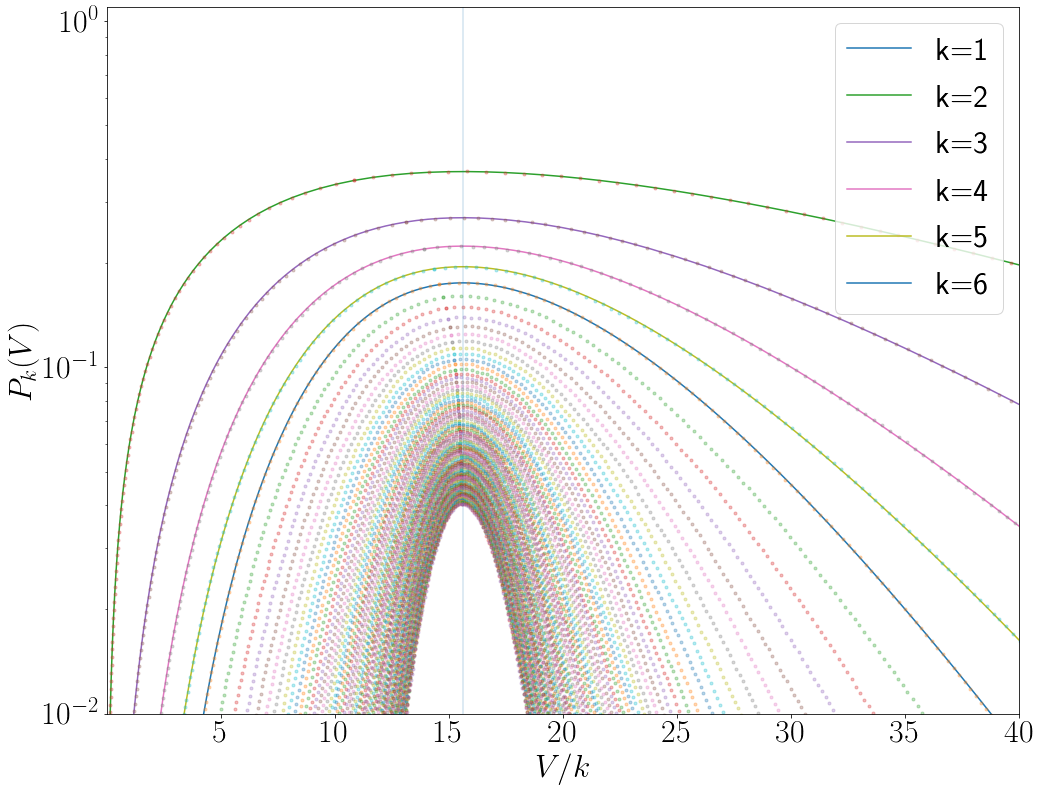

In [133]:
for k in range(1,100):
    vol = DDCDFs[k].f.x
    ck = np.max([k-1,1])
    lab = ""
    if (ck < 6) :
        lab = "k="+str(k)
        plt.plot(vol,Erlang(k-1,1/2.5**3,vol)/ck,'-',label=lab)
    plt.semilogy(vol/ck, DDPks[k](vol),'.',alpha=.3) 
plt.axhline(np.exp(-2.5**3))
plt.xlim([.01e0,40])
plt.ylim([1e-2,11e-1])
plt.ylabel(r"$P_{k}(V)$" )
plt.xlabel(r"$V/k$" )
plt.legend()
plt.axvline(Vbar,alpha=.2);

In [225]:
kneighbors = np.arange(1000)+1
dDDCDFs  = CDFkNNDD(x_dm, kneighbors=kneighbors, periodic=250,compress="log",Ninterpolants=500)


In [228]:
dDDPks = { k-1: interp1d(dDDCDFs[k].f.x,dDDCDFs[k-1].cdf(dDDCDFs[k].f.x)-dDDCDFs[k].cdf(dDDCDFs[k].f.x), \
    bounds_error=False,fill_value=(0,0))  
    for k in kneighbors[1:]}
vols = np.logspace(-3,3.3,60)*dVbar

dDDCa = np.zeros((len(vols),len(kneighbors)-1))
for i, vol in enumerate(vols):
    dDDCa[i][:] = [dDDPks[k](vol) for k in kneighbors[:-1]]
dDDC = [stats.rv_discrete(values=(kneighbors[:-1],np.round(dDDCa[i]/np.sum(dDDCa[i]), decimals=7)),name='CountsInCell') \
    for i, vol in enumerate(vols)]

In [229]:
dDDC[0].pmf(1)

0.7911896

No handles with labels found to put in legend.


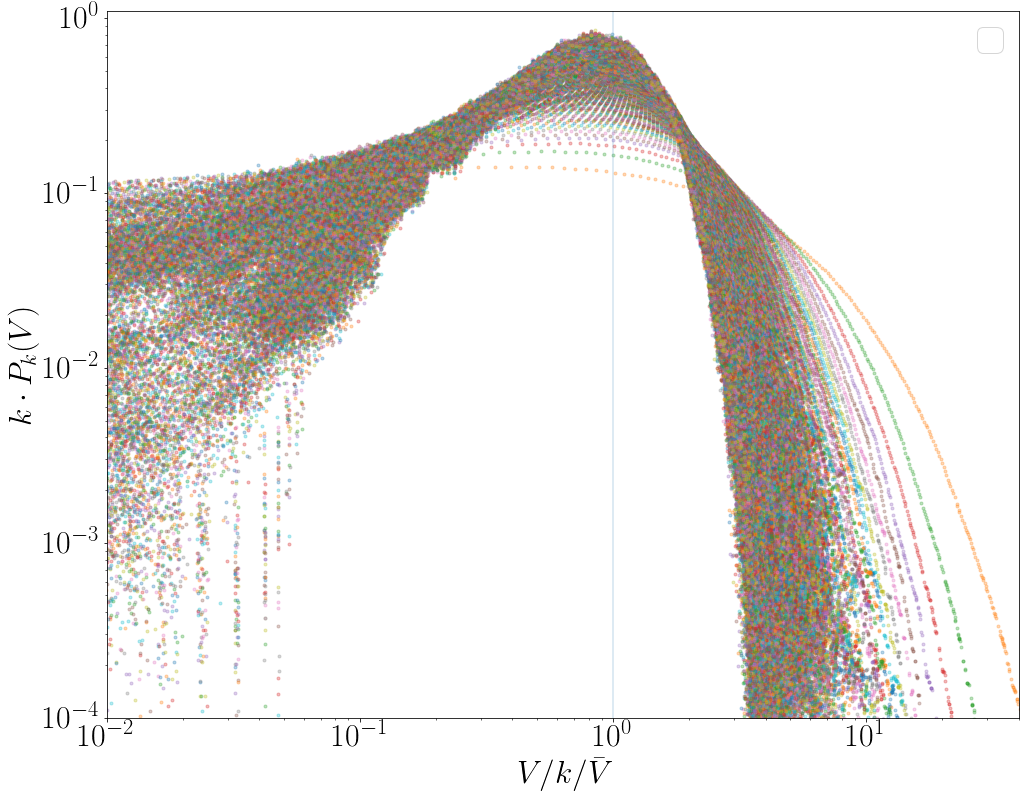

In [232]:
for k in range(1,1000):
    vol = dDDCDFs[k].f.x
    ck = np.max([k-1,1])
    lab = ""
    plt.loglog(vol/ck/dVbar, dDDPks[k](vol)*ck,'.',alpha=.3) 
plt.axhline(np.exp(-2.5**3))
plt.xlim([.01e0,40])
plt.ylim([1e-4,11e-1])
plt.ylabel(r"$k \cdot P_{k}(V)$" )
plt.xlabel(r"$V/k/\bar{V}$" )
plt.legend()
plt.axvline(1,alpha=.2);

No handles with labels found to put in legend.


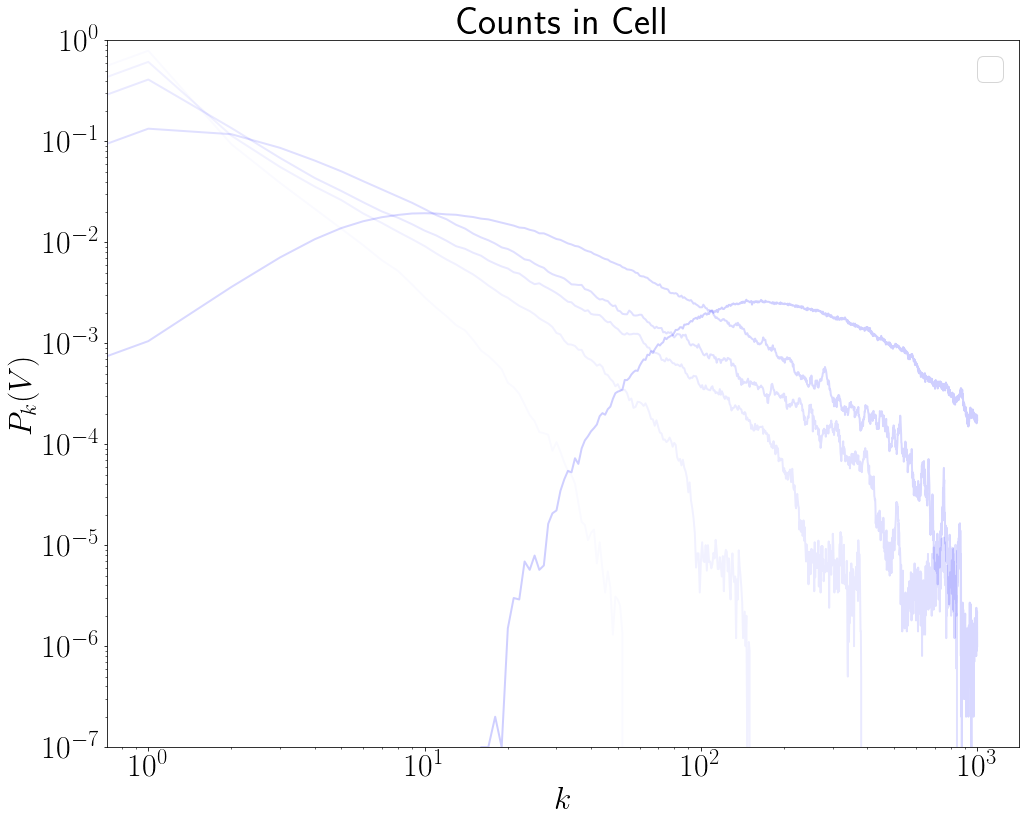

In [234]:
ax = plt.gca()
for i in range(0,len(vols),10):
    c = next(ax._get_lines.prop_cycler)['color']
    plt.loglog(kneighbors-1,dDDC[i].pmf(kneighbors-1),'-',lw=2,ms=8,alpha=.02+i/300,color="blue")

plt.title("Counts in Cell")
#plt.xlim([1.e0,300])
plt.ylim([1e-7,1e0])
plt.ylabel(r"$P_{k}(V)$" )
plt.xlabel(r"$k$" )
plt.legend(loc="upper right")
plt.axhline(Vbar,alpha=.2);


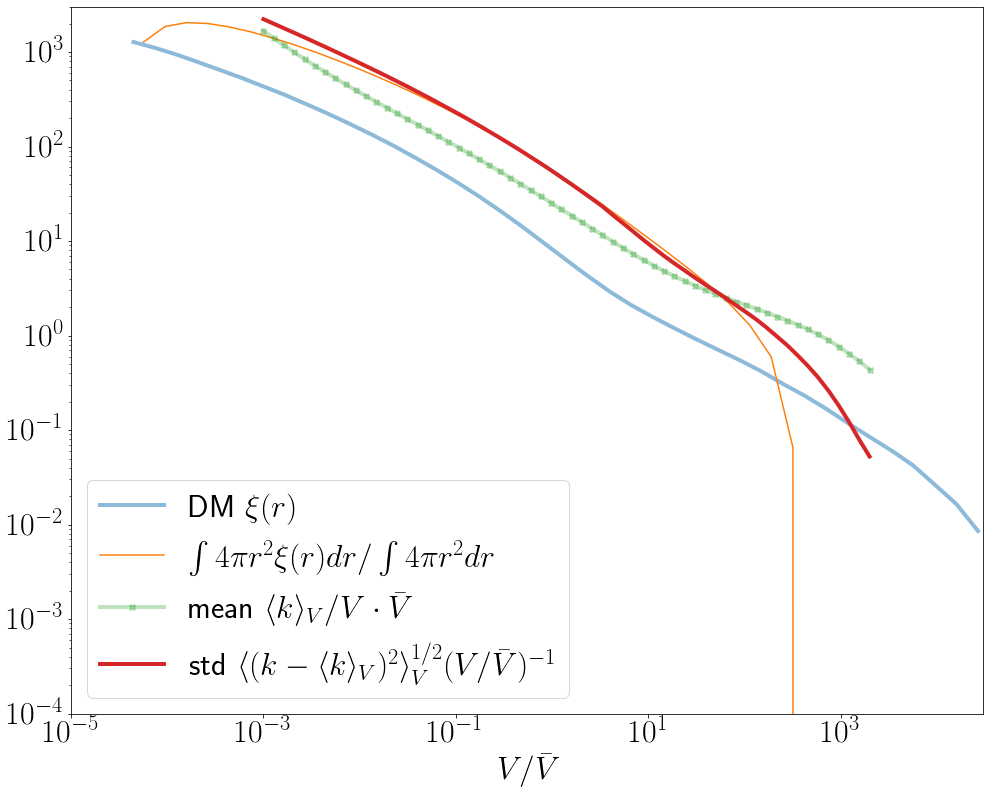

In [263]:
#vols = np.logspace(-3,4.7,100)*dVbar
kstat = np.array([dDDC[i].stats(moments="mvsk") for i, vol in enumerate(vols)])
kstd = np.array([dDDC[i].std() for i, vol in enumerate(vols)])
ax = plt.gca()

nv = vols/dVbar

xivol = 4*np.pi/3*dm_xi["ravg"]**3
plt.plot(xivol/dVbar, dm_xi["xi"], label=r"DM $\xi(r)$", linewidth=4, alpha=0.5)
plt.plot(intxiV/dVbar, intxi,label=r"$\int 4\pi r^2 \xi(r)dr/\int 4\pi r^2 dr$")

plt.loglog(nv, (kstat[:,0])/nv,'X-',label=r"mean $\langle k \rangle_V/V \cdot \bar{V}$",alpha=.3,lw=4)
#plt.plot(nv, kstat[:,1]/vols, \
#    label=r"var $\langle (k - \langle k \rangle_V)^2 \rangle_V (V /\bar{V})^{-1}$")
c = next(ax._get_lines.prop_cycler)['color']
plt.plot(nv, kstd/nv, lw=4, color=c, \
    label=r"std $\langle (k - \langle k \rangle_V)^2 \rangle_V^{1/2} (V /\bar{V})^{-1}$")
#plt.plot(pnv, pkstd/nv, lw=2, alpha=.3, color=c, \
#    label=r"std poisson")
#plt.plot([1e-2,1e2],np.array([1e-2,1e2])**(-1/2.5)*4, label=r"$\propto V^{-2/5}$")
#plt.plot(nv  , kstat[:,2]/nv**(-1/2),alpha=.3,lw=4, \
#    label=r"$\langle (k - \langle k \rangle)^3 \rangle_V (V /\bar{V})^{-1/2}$")
#plt.plot(nv  , kstat[:,3]/nv**(-1),alpha=.3,lw=4, \
#    label=r"$\langle (k - \langle k \rangle)^4 \rangle_V (V /\bar{V})^{-1}$")
plt.xlabel(r"$V/\bar{V}$")
plt.xlim(.00001,3e4)
plt.ylim(.0001,3e3)
plt.legend();

In [220]:
dVbar

15.625